# GSP Final Project
In this notebook, we will demonstrate estimation of graph signals using a GSP-based technique vs.  a deep-learning-based technique. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse as ssparse
import scipy.io as sio
import torch_geometric as tg
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

colab = False
if colab:
    drive_path = './' # For colab integration type here your path and set 'colab = True'
else:
    drive_path = './'

# Set device CPU as default 
device = 'cpu'

In [2]:
# Enable CUDA, use if supported
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
  # print(gpu_info)
    print('Connected to a GPU')

Connected to a GPU


In [3]:
# To empty GPU cache - No need to run
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

## Task

$$\mathbf{x} \longrightarrow  \boxed{\text{Physical Model}} \longrightarrow \mathbf{y}  \longrightarrow \boxed{\text{Estimator}}  \longrightarrow \hat{\mathbf{x}}$$ 

### Physical Model
$$ \mathbf{y} = \mathbf{g}(\mathbf{x};\mathbf{L}) + \mathbf{w} $$

- $\mathbf{x} \sim p(\mathbf{x})$.
- $\mathbf{g}$ - a non-linear measurement function.
- $\mathbf{L}$ - the Laplacian matrix of the graph.
 
### Estimator
- $\mathbf{y}$ - input of the estimator
- $\mathbf{x}$ - ground-truth corresponding label
- The estimator is given a dataset pairs of $\{\mathbf{x_t}, \mathbf{y_t} \}_t$ for training.

**Goal**: The estimator should recover $\mathbf{x}$ out of $\mathbf{y}$ with minimum MSE.
#### GSP-based

Use a GSP-based technique for estimation.

#### GNN-based

Use a GNN deep-learning architecture for estimation.

**NOTE:**  $\mathbf{y}$ is the input to the DP model and $\mathbf{x}$ is the output (i.e., the label) not vise versa!

## Part 1: Physical Model

In [3]:
def laplacian_evd(Y):
    L = - np.imag(Y)
    Lambda, V = np.linalg.eig(L)
    Lambda = np.real(Lambda)
    sorted_indices = np.argsort(Lambda)
    Lambda = Lambda[sorted_indices]
    Lambda = np.diag(Lambda)
    V = V[:, sorted_indices]
    return L, Lambda, V
    
def g_xL(Y, x):
    v = np.exp(1j * x)
    g_x = np.real(v * np.conj(Y @ v))
    return g_x
    
def generate_data(nt, Y, Lambda, V, beta=3, c_ww=0.05):
    N = Y.shape[0]
    xt = (V[:, 1:] @ np.random.multivariate_normal(np.zeros(N - 1), beta * np.diag(1 / np.diag(Lambda)[1:]), nt).T).T
    if nt == 1:
        xt = xt[0, :]
    
    yt = np.zeros(xt.shape)
    for t in range(0, nt):
        yt[t] = g_xL(Y, xt[t])
    yt += np.sqrt(c_ww) * np.random.randn(yt.shape[0], yt.shape[1])
    
    return xt, yt

## Part 2: GSP-LMMSE Estimator

The GSP-LMMSE estimator is defined as an estimator which minimize the MSE among all estimators in the form of a graph filter:
$$
\{\bf{h}, \bf{b} \} = \text{argmin}~ \mathbb{E} [(\bf{x} - \hat{\bf{x}}(\bf{y}))^2]
$$

where $\hat{\bf{x}}(\bf{y}) =  \bf{V} \text{diag} (\bf{h}) \bf{V}^T \bf{y}+ \bf{b}$.

A closed form expression would be:
$$ \hat{\bf{x}}(\bf{y}) =  \bf{V} \text{diag} (\bf{d}_{\bf{xy}}\oslash \bf{d}_{\bf{yy}}) \bf{V}^T \bf{y} + \bar{\bf{x}}$$

where $\bf{d}_{\bf{xy}} := \text{diag}(\text{cov}(\bf{V}^T \bf{x}, \bf{V}^T \bf{y}))$, $\bf{d}_{\bf{yy}} := \text{diag}(\text{var}(\bf{V}^T \bf{y}))$ and $\bar{\bf{x}} :=\mathbb{E}\bf{x}$

In [4]:
def train_gsp_lmmse_estimator(xt, yt, V):
    xt = xt.T     # column vectors representation
    yt = yt.T     # column vectors representation

    xt_mean = np.mean(xt, axis=1)[:, np.newaxis]
    yt_mean = np.mean(yt, axis=1)[:, np.newaxis]

    d_xy = np.mean( ( V.T @ (xt - xt_mean) ) * ( V.T @ (yt - yt_mean) ) , axis=1)

    d_yy = np.mean( ( V.T @ (yt - yt_mean) ) ** 2 , axis=1)
    
    h = d_xy / d_yy

    return h, xt_mean

def test_estimator_mse(h, b, xt_test, yt_test, V):
    xt_test = xt_test.T     # column vectors representation
    yt_test = yt_test.T     # column vectors representation

    err = V @ np.diag(h) @ V.T @ yt_test + b - xt_test
    s_mse = np.linalg.norm(err, axis=0)
    mse = np.mean(s_mse)
    return mse


## Part 3: GNN and Deep Learning based Estimation

### Define Model Architecture

In [5]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_dim = 16
        K = 30
        self.conv1 = tg.nn.ChebConv(1, hidden_dim,  K=K, normalization=None)
        self.conv2 = tg.nn.ChebConv(hidden_dim, hidden_dim,  K=K, normalization=None)
        self.conv3 = tg.nn.ChebConv(hidden_dim, hidden_dim,  K=K, normalization=None)
        self.linear = torch.nn.Linear(hidden_dim, 1, )
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = self.relu1(x)  

        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = self.relu2(x)  

        x = self.conv3(x, edge_index, edge_weight=edge_weight)

        x = self.linear(x)

        return x

### Define training function

In order to run on GPU via CUDA set device accordingly.

In [6]:
def train_model(model, train_data, valid_data, batch_size=500, valid_batch_size = 200, epochs=40, lr=0.01, weight_decay=1e-4, device='cpu'):
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=valid_batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_mse, valid_mse = [], []
    
    best_state_dict = None
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
                
        # Training
        model.train() 
        # train_loss = 0
        # iters = 0
        # test_loss = None
        for data in train_loader:
            data = data.to(device) 
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            # test_loss = float(loss.item())
            # train_loss += float(loss.item())
            # iters += 1
        test_loss = evaluate_model(model, train_loader, device=device)
        train_mse.append(test_loss)

        # Validation
        valid_loss = evaluate_model(model, valid_loader, device=device)
        valid_mse.append(valid_loss)

        if valid_mse[-1] <= min(valid_mse):
            print("Current State Saved")
            # torch.save(model.state_dict(), path + f"{valid_mse[-1]}.pk")
            best_state_dict = model.state_dict()
            best_val_loss = valid_mse[-1]

        print(f"Epoch: {epoch}, Train MSE {train_mse[-1]}, Validation MSE {valid_mse[-1]}")
    
    return train_mse, valid_mse, best_state_dict, best_val_loss
        
def evaluate_model(model, test_loader, device='cpu'):
    # criterion = nn.MSELoss(reduction='sum')
    N = test_loader.dataset[0].x.shape[0]
    model.eval()
    mse = 0
    iters = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device) 
    
            output = model(data)
            # loss = criterion(output,data.y)
            # mse += float(loss.item())
            # print(f"{output.shape}, {data.y.shape}")
            err = output - data.y
            err = err.view(-1, N)
            s_mse = torch.linalg.norm(err, dim=1)
            m_mse = torch.mean(s_mse)
            mse += m_mse
            iters += 1
    # print(s_mse)
    # print(f"{s_mse.shape}")
    # print(f"{m_mse}")
    return float(mse) / iters

def plot_learning_curve(train_mse, valid_mse):
    plt.figure(figsize=(10, 5))
    plt.plot(train_mse, label='Training MSE', color='blue')
    plt.plot(valid_mse, label='Validation MSE', color='black')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

## Part 4: Train
We will test the estimators performances in different dataset sizes $n_t$ and compare the results.
Define the $n_t$'s we would like to test:

In [7]:
nt_arr = np.arange(1, 6)
nt_arr = np.power(10, nt_arr)
print(f"nt_array = {nt_arr}")

nt_array = [    10    100   1000  10000 100000]


Generate a dataset of size $\texttt{nt_array[i]}$.
Please select the $i$.
Then we will train the model for this dataset.
You can adjust th hyper-parameters for better convergence.

In [8]:
filename = drive_path + 'grid_data_ieee118cdf.mat'
grid_data = sio.loadmat(filename)
Y = grid_data['Y']
N = Y.shape[0]
L, Lambda, V = laplacian_evd(Y)
c_ww = 0.4
L_sparse = ssparse.csr_matrix(np.diag(np.diag(L)) -L)
edge_index, edge_weight = tg.utils.from_scipy_sparse_matrix(L_sparse)
edge_weight = edge_weight.to(dtype=torch.float32)

Current State Saved
Epoch: 0, Train MSE 7.953886413574219, Validation MSE 8.059751892089844
Current State Saved
Epoch: 1, Train MSE 7.123298645019531, Validation MSE 7.234470367431641
Current State Saved
Epoch: 2, Train MSE 6.591330718994141, Validation MSE 6.688839721679687
Current State Saved
Epoch: 3, Train MSE 6.262735748291016, Validation MSE 6.348479080200195
Current State Saved
Epoch: 4, Train MSE 6.01898193359375, Validation MSE 6.096660232543945
Current State Saved
Epoch: 5, Train MSE 5.752322387695313, Validation MSE 5.822059631347656
Current State Saved
Epoch: 6, Train MSE 5.562438583374023, Validation MSE 5.625315093994141
Current State Saved
Epoch: 7, Train MSE 5.355692291259766, Validation MSE 5.4111988067626955
Current State Saved
Epoch: 8, Train MSE 5.228768539428711, Validation MSE 5.2752433776855465
Current State Saved
Epoch: 9, Train MSE 5.1038257598876955, Validation MSE 5.146618270874024
Current State Saved
Epoch: 10, Train MSE 4.994940948486328, Validation MSE 5.0

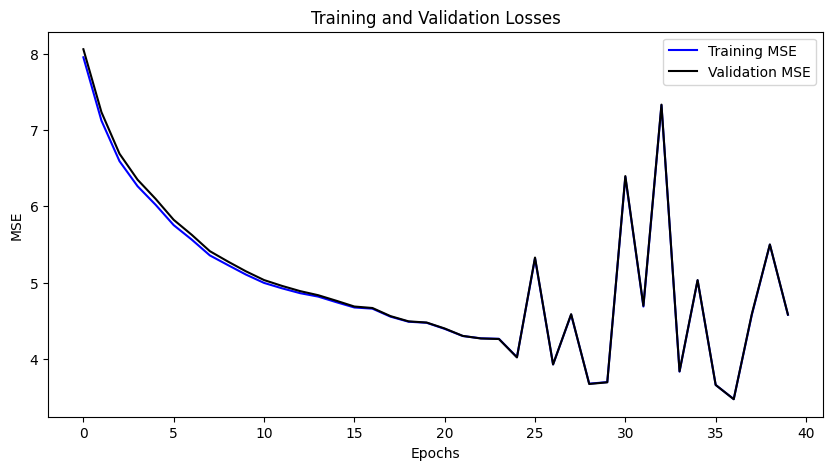

In [10]:
i = 3
nt = nt_arr[i]
xt_total, yt_total = generate_data(nt, Y, Lambda, V, c_ww=c_ww)

lr = 0.02
batch_size = 50
# path = drive_path + f"model1_nt_{nt}_lr_{lr}_bs_{batch_size}"
GNN_model = GNN()

xt_total = torch.tensor(xt_total, dtype=torch.float32)
yt_total = torch.tensor(yt_total, dtype=torch.float32)

# NOTE: yt is the input for the model, and xt is the label, in Data object x is the input and y is the label!
total_data = [Data(x=yt_total[i].unsqueeze(-1), y=xt_total[i].unsqueeze(-1), edge_index=edge_index, edge_attr=edge_weight) for i in range(len(yt_total))]

train_data = total_data[:int(len(total_data) * 0.8)]
valid_data = total_data[int(len(total_data) * 0.8):]

GNN_model.to(device)

train_mse, valid_mse, best_state_dict, best_val_loss = train_model(GNN_model, train_data, valid_data, batch_size=batch_size, lr = lr, device=device)
torch.save(best_state_dict, drive_path + f"models/model1_nt_{nt}_lr_{lr}_bs_{batch_size}_loss_{best_val_loss}.pk")

plot_learning_curve(train_mse, valid_mse)

## Part 4: Comparison
After we train the DL model for all data sizes we will compare its performance to those of the GSP-LMMSE estimator.

In [9]:
import glob

models_prop = []
models_path = drive_path + "models/*"
files = sorted([file for file in glob.glob(models_path)])
for file in files:
    file = file.replace("\\", "/")
    name = ".".join(file.split("/")[-1].split(".")[0:-1])
    # print(name)
    prop = name.split("_")
    models_prop.append({})
    models_prop[-1]["file"] = file
    models_prop[-1]["nt"] = int(prop[2])
    models_prop[-1]["loss"] = float(prop[-1])
    # print(f"nt: {models_prop[-1]["nt"]} loss: {models_prop[-1]['loss']}")

# print(models_prop)
best_models = {}

for nt in nt_arr:
    filtered_prop = [prop for prop in models_prop if prop['nt'] == nt]
    print(filtered_prop)
    if filtered_prop:
        best_models[nt] = (min(filtered_prop, key=lambda x: x['loss']))

for md in best_models:
    print(f"nt: {best_models[md]['nt']} loss: {best_models[md]['loss']}")

[{'file': './models/model_nt_10_lr_0.02_bs_5_loss_8.850927352905273.pk', 'nt': 10, 'loss': 8.850927352905273}]
[{'file': './models/model1_nt_100_lr_0.017_bs_75_loss_7.788823127746582.pk', 'nt': 100, 'loss': 7.788823127746582}, {'file': './models/model1_nt_100_lr_0.01_bs_100_loss_15.756387710571289.pk', 'nt': 100, 'loss': 15.756387710571289}, {'file': './models/model1_nt_100_lr_0.01_bs_10_loss_9.4478178024292.pk', 'nt': 100, 'loss': 9.4478178024292}, {'file': './models/model1_nt_100_lr_0.02_bs_5_loss_6.5818047523498535.pk', 'nt': 100, 'loss': 6.5818047523498535}, {'file': './models/model1_nt_100_lr_0.05_bs_5_loss_8.85502815246582.pk', 'nt': 100, 'loss': 8.85502815246582}]
[{'file': './models/model1_nt_1000_lr_0.02_bs_5_loss_3.391406774520874.pk', 'nt': 1000, 'loss': 3.391406774520874}, {'file': './models/model1_nt_1000_lr_0.02_bs_75_loss_7.407615661621094.pk', 'nt': 1000, 'loss': 7.407615661621094}]
[{'file': './models/model1_nt_10000_lr_0.01_bs_100_loss_5.089002227783203.pk', 'nt': 100

### MSE vs. data-size $n_t$

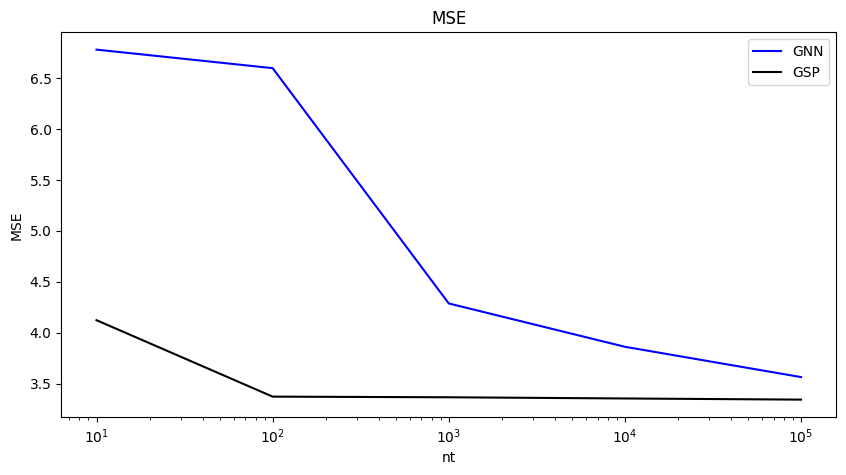

In [12]:
gnn_mse_nt = np.full(len(nt_arr), np.inf)
gsp_mse_nt = np.full(len(nt_arr), np.inf)

for i in range(len(nt_arr)):
    nt = nt_arr[i]
    xt_train_gsp, yt_train_gsp = generate_data(nt, Y, Lambda, V, c_ww=c_ww)
    xt_test, yt_test = generate_data(50000, Y, Lambda, V, c_ww=c_ww)
    
    h_gsp, b_gsp = train_gsp_lmmse_estimator(xt_train_gsp, yt_train_gsp, V)
    mse_gsp = test_estimator_mse(h_gsp, b_gsp, xt_test, yt_test, V)
    gsp_mse_nt[i] = mse_gsp
    
    if nt not in best_models:
        continue
        
    yt_test_torch = torch.tensor(yt_test, dtype=torch.float32)
    xt_test_torch = torch.tensor(xt_test, dtype=torch.float32)
        
    GNN_model = GNN()
    GNN_model.load_state_dict(torch.load(best_models[nt]['file']))
    GNN_model.to(device)
    
    test_data = [Data(x=yt_test_torch[i].unsqueeze(-1), y=xt_test_torch[i].unsqueeze(-1), edge_index=edge_index, edge_attr=edge_weight) for i in range(len(yt_test))]
    test_loader = DataLoader(test_data, batch_size=200, shuffle=False)

    mse_gnn = evaluate_model(GNN_model, test_loader, device=device)
    gnn_mse_nt[i] = mse_gnn

plt.figure(figsize=(10, 5))
plt.semilogx(np.array(nt_arr)[gnn_mse_nt != np.inf], gnn_mse_nt[gnn_mse_nt != np.inf], label='GNN', color='blue')
plt.semilogx( np.array(nt_arr), gsp_mse_nt, label='GSP', color='black')
plt.title('MSE')
plt.xlabel('nt')
plt.ylabel('MSE')
plt.legend()
plt.show()

### MSE vs. SNR

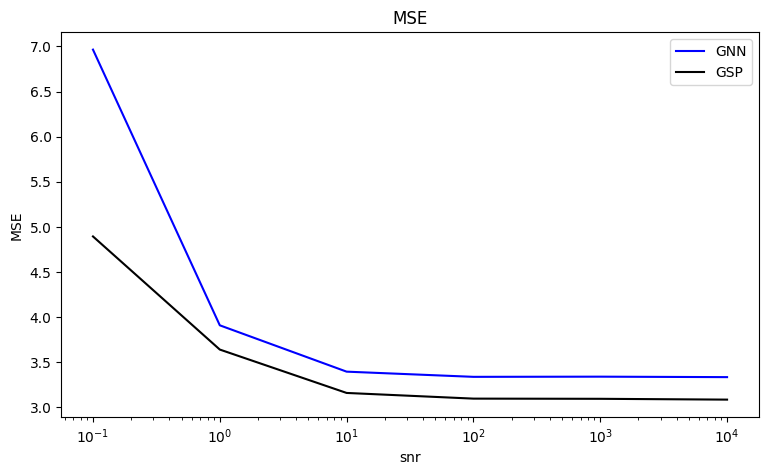

In [13]:
c_ww_arr = np.arange(1, -5, -1, dtype=float)
c_ww_arr = np.power(10, c_ww_arr)
snr_arr = 1 / c_ww_arr

gnn_mse_snr = np.full(len(c_ww_arr), np.inf)
gsp_mse_snr = np.full(len(c_ww_arr), np.inf)

GNN_model = GNN()
nt = nt_arr[-1]
GNN_model.load_state_dict(torch.load(best_models[nt]['file']))
GNN_model.to(device)

for i in range(len(c_ww_arr)):
    c_ww = c_ww_arr[i]
    xt_train_gsp, yt_train_gsp = generate_data(nt, Y, Lambda, V, c_ww=c_ww)
    xt_test, yt_test = generate_data(50000, Y, Lambda, V, c_ww=c_ww)
    
    h_gsp, b_gsp = train_gsp_lmmse_estimator(xt_train_gsp, yt_train_gsp, V)
    mse_gsp = test_estimator_mse(h_gsp, b_gsp, xt_test, yt_test, V)
    gsp_mse_snr[i] = mse_gsp
        
    yt_test_torch = torch.tensor(yt_test, dtype=torch.float32)
    xt_test_torch = torch.tensor(xt_test, dtype=torch.float32)
    
    test_data = [Data(x=yt_test_torch[i].unsqueeze(-1), y=xt_test_torch[i].unsqueeze(-1), edge_index=edge_index, edge_attr=edge_weight) for i in range(len(yt_test))]
    test_loader = DataLoader(test_data, batch_size=200, shuffle=False)

    mse_gnn = evaluate_model(GNN_model, test_loader, device=device)
    gnn_mse_snr[i] = mse_gnn

plt.figure(figsize=(9, 5))
plt.semilogx(snr_arr, gnn_mse_snr, label='GNN', color='blue')
plt.semilogx(snr_arr, gsp_mse_snr, label='GSP', color='black')
plt.title('MSE')
plt.xlabel('snr')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Mismatch

#### MSE vs. probability of connection/disconnection

0
1
2
3
4
5


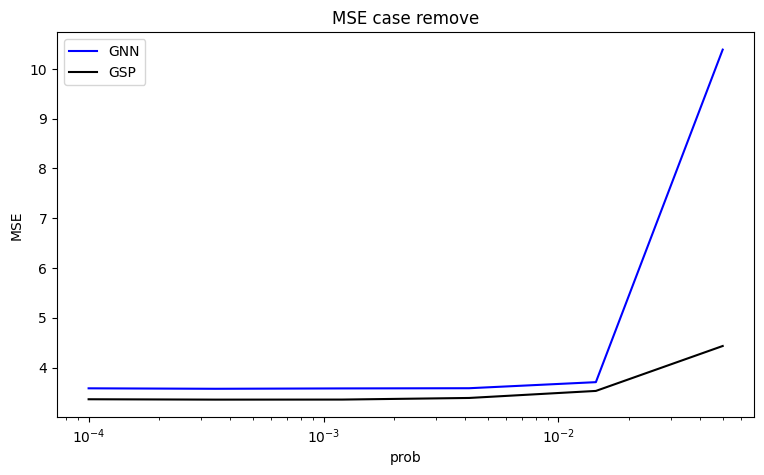

In [10]:
def modify_edges(Y, prob_conn, prob_dis):
    N = Y.shape[0]
    
    arr = Y[np.tri(N) == 0]
    arr = arr[arr != 0]
    mean_G = np.mean(np.real(arr))
    std_G = min(abs(mean_G)/3., np.std(np.real(arr)))
    mean_B = np.mean(np.imag(arr))
    std_B = min(abs(mean_G)/3., np.std(np.imag(arr)))

    # Find unconnected edges
    temp = Y + np.tri(N)
    unconnected = np.where(temp == 0)

    # Find connected edges
    temp = np.copy(Y)
    temp[np.tri(N) == 1] = 0
    connected = np.where(temp != 0)

    t = 0
    while True:
        Y_mod = np.copy(Y)

        for idx in range(len(unconnected[0])):
            if np.random.rand() <= prob_conn:
                i, j = unconnected[0][idx], unconnected[1][idx]
                g_ij = -abs(np.random.normal(mean_G, std_G))
                b_ij = abs(np.random.normal(mean_B, std_B))
                y_ij = g_ij + 1j * b_ij
                Y_mod[i, i] -= y_ij
                Y_mod[j, j] -= y_ij
                Y_mod[i, j] += y_ij
                Y_mod[j, i] += y_ij

        for idx in range(len(connected[0])):
            if np.random.rand() <= prob_dis:
                i, j = connected[0][idx], connected[1][idx]
                y_ij = Y_mod[i, j]
                Y_mod[i, i] += y_ij
                Y_mod[j, j] += y_ij
                Y_mod[i, j] = 0
                Y_mod[j, i] = 0

        L_mod, Lambda_mod, V_mod = laplacian_evd(Y_mod)
        
        if abs(Lambda_mod[1, 1]) > 10 ** -5:
            return Y_mod, L_mod, Lambda_mod, V_mod
        elif t > 50:  # time-out
            raise ValueError("Generating connected graph failed")
        t += 1

prob_arr = np.logspace(-4, np.log10(0.05), num=6)[::-1]

gnn_mse_prob = np.full(len(prob_arr), np.inf)
gsp_mse_prob = np.full(len(prob_arr), np.inf)

GNN_model = GNN()
nt = nt_arr[-1]
GNN_model.load_state_dict(torch.load(best_models[nt]['file']))
GNN_model.to(device)

plot_type = "remove"

for i in range(len(prob_arr)):
    iters = 10
    mse_gsp = 0
    mse_gnn = 0
    if plot_type == "both":
            prob_conn = prob_arr[i]
            prob_dis = prob_arr[i]
    elif plot_type == "add":
        prob_conn = prob_arr[i]
        prob_dis = 0
    else:
        prob_conn = 0
        prob_dis = prob_arr[i]
    for _ in range(iters):
        Y_mod, L_mod, Lambda_mod, V_mod = modify_edges(Y, prob_conn, prob_dis)
        xt_train_gsp, yt_train_gsp = generate_data(nt, Y, Lambda, V, c_ww=c_ww)
        xt_test, yt_test = generate_data(5000, Y_mod, Lambda_mod, V_mod, c_ww=c_ww)
        
        h_gsp, b_gsp = train_gsp_lmmse_estimator(xt_train_gsp, yt_train_gsp, V)
        mse_gsp += test_estimator_mse(h_gsp, b_gsp, xt_test, yt_test, V)
            
        yt_test_torch = torch.tensor(yt_test, dtype=torch.float32)
        xt_test_torch = torch.tensor(xt_test, dtype=torch.float32)
        
        L_sparse = ssparse.csr_matrix(np.diag(np.diag(L_mod)) - L_mod)
        edge_index_mod, edge_weight_mod = tg.utils.from_scipy_sparse_matrix(L_sparse)
        edge_weight_mod = edge_weight_mod.to(dtype=torch.float32)
        
        test_data = [Data(x=yt_test_torch[i].unsqueeze(-1), y=xt_test_torch[i].unsqueeze(-1), edge_index=edge_index_mod, edge_attr=edge_weight_mod) for i in range(len(yt_test))]
        test_loader = DataLoader(test_data, batch_size=200, shuffle=False)
    
        mse_gnn += evaluate_model(GNN_model, test_loader, device=device)
        
    gsp_mse_prob[i] = mse_gsp / iters
    gnn_mse_prob[i] = mse_gnn / iters
    print(i)

plt.figure(figsize=(9, 5))
plt.semilogx(prob_arr, gnn_mse_prob, label='GNN', color='blue')
plt.semilogx(prob_arr, gsp_mse_prob, label='GSP', color='black')
plt.title(f'MSE case {plot_type}')
plt.xlabel('prob')
plt.ylabel('MSE')
plt.legend()
plt.show()


### MSE vs. no. of edges added/removed